In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_batch = 8
test_batch = 120

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



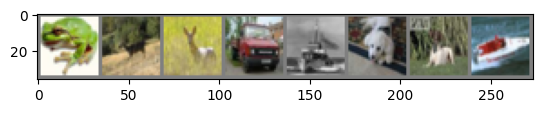

frog  deer  deer  truck ship  dog   dog   ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(train_batch)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 25, 5),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, 5),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 5 * 5, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x



net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 25, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1250, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, 

In [5]:
total_params = sum(p.numel() for p in net.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 164310


In [6]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 28, 28]           1,900
       BatchNorm2d-2           [-1, 25, 28, 28]              50
              ReLU-3           [-1, 25, 28, 28]               0
         MaxPool2d-4           [-1, 25, 14, 14]               0
            Conv2d-5           [-1, 50, 10, 10]          31,300
       BatchNorm2d-6           [-1, 50, 10, 10]             100
              ReLU-7           [-1, 50, 10, 10]               0
         MaxPool2d-8             [-1, 50, 5, 5]               0
            Linear-9                  [-1, 100]         125,100
      BatchNorm1d-10                  [-1, 100]             200
             ReLU-11                  [-1, 100]               0
          Dropout-12                  [-1, 100]               0
           Linear-13                   [-1, 50]           5,050
      BatchNorm1d-14                   

In [7]:
def model_acc():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
def class_acc():
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [8]:
def count_ops(model, input_shape):
    add_ops, mul_ops, max_ops, total_ops = 0, 0, 0, 0

    # Calculating the number of operations for the Conv2d layers
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias = layer.in_channels, layer.out_channels, layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.groups, layer.bias is not None
            input_shape = (input_shape[0], in_channels, input_shape[1], input_shape[2])
            output_shape = (input_shape[0], out_channels, (input_shape[2] + 2*padding[0] - dilation[0]*(kernel_size[0]-1)-1)//stride[0]+1, (input_shape[3] + 2*padding[1] - dilation[1]*(kernel_size[1]-1)-1)//stride[1]+1)
            n_ops = output_shape[1] * (2*kernel_size[0]*kernel_size[1]*input_shape[1] - 1) * output_shape[2] * output_shape[3]
            if bias:
                n_ops += output_shape[1] * output_shape[2] * output_shape[3]
            add_ops += n_ops
            mul_ops += n_ops

            input_shape = output_shape

    # Calculating the number of operations for the MaxPool2d layers
    for name, layer in model.named_modules():
        if isinstance(layer, nn.MaxPool2d):
            kernel_size, stride, padding, dilation = layer.kernel_size, layer.stride, layer.padding, layer.dilation
            output_shape = (input_shape[0], input_shape[1], (input_shape[2] + 2*padding - dilation*(kernel_size-1)-1)//stride+1, (input_shape[3] + 2*padding - dilation*(kernel_size-1)-1)//stride+1)
            n_ops = output_shape[1] * kernel_size * kernel_size * output_shape[2] * output_shape[3]
            max_ops += n_ops
            total_ops += n_ops

            input_shape = output_shape

    # Calculating the number of operations for the Linear layers
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            in_features, out_features, bias = layer.in_features, layer.out_features, layer.bias is not None
            n_ops = in_features * out_features
            add_ops += n_ops
            mul_ops += n_ops * 2
            total_ops += n_ops * 2
            if bias:
                add_ops += out_features
                total_ops += out_features
        
    print("Nombre d'operations d'additions :" , add_ops  ,"\n")
    print("Nombre d'operations de multiplication :" , mul_ops  ,"\n")
    print("Nombre d'operations de maximisation :" , max_ops  ,"\n")
    print("Nombre total d'operations  :" , total_ops  ,"\n")

    return add_ops, mul_ops, max_ops, total_ops
count_ops(net, input_shape=(3,32,32))

Nombre d'operations d'additions : 34570660 

Nombre d'operations de multiplication : 34701000 

Nombre d'operations de maximisation : 30000 

Nombre total d'operations  : 291160 



(34570660, 34701000, 30000, 291160)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
model_acc()
class_acc()

Accuracy of the network on the 10000 test images: 9 %
Accuracy for class: plane is 6.6 %
Accuracy for class: car   is 0.7 %
Accuracy for class: bird  is 1.0 %
Accuracy for class: cat   is 19.0 %
Accuracy for class: deer  is 15.5 %
Accuracy for class: dog   is 8.0 %
Accuracy for class: frog  is 3.8 %
Accuracy for class: horse is 2.0 %
Accuracy for class: ship  is 5.5 %
Accuracy for class: truck is 39.8 %


In [11]:
import time
total_time = time.time()
for epoch in range(15):  # loop over the dataset multiple times
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds')
    net.eval()
    model_acc()
    net.train()
total_time = time.time() - total_time
net.eval()
class_acc()
net.train()
print(f'Training time :  {total_time:.2f} seconds')
print('Finished Training')

[1,  2000] loss: 1.853
[1,  4000] loss: 1.650
[1,  6000] loss: 1.542
Time taken for epoch 1: 40.19 seconds
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.462
[2,  4000] loss: 1.403
[2,  6000] loss: 1.379
Time taken for epoch 2: 40.80 seconds
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 1.317
[3,  4000] loss: 1.302
[3,  6000] loss: 1.256
Time taken for epoch 3: 40.40 seconds
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 1.223
[4,  4000] loss: 1.237
[4,  6000] loss: 1.199
Time taken for epoch 4: 42.53 seconds
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 1.160
[5,  4000] loss: 1.168
[5,  6000] loss: 1.151
Time taken for epoch 5: 39.57 seconds
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 1.102
[6,  4000] loss: 1.109
[6,  6000] loss: 1.110
Time taken for epoch 6: 38.40 seconds
Accuracy of the network on the 10000 test images: 70 %
[7,  2000] loss: 1.079
[7,  

Let's quickly save our trained model:



In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



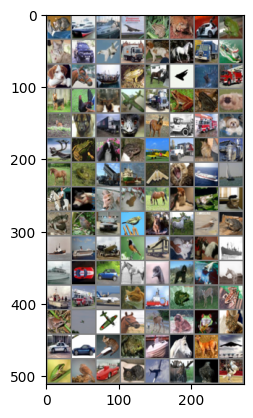

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [15]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane plane plane plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.9 %
Accuracy for class: car   is 73.0 %
Accuracy for class: bird  is 35.5 %
Accuracy for class: cat   is 48.1 %
Accuracy for class: deer  is 52.5 %
Accuracy for class: dog   is 49.5 %
Accuracy for class: frog  is 79.8 %
Accuracy for class: horse is 64.9 %
Accuracy for class: ship  is 83.1 %
Accuracy for class: truck is 72.0 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter